In [61]:
import sys
print(sys.version)

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 05:52:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [62]:
import os
import json
import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrices
from matplotlib import pyplot as plt
import rpy2

In [63]:
%matplotlib inline

# Statistical analysis of feature computations results


## 1. Data importation and manipulation

In [64]:
def get_path_to_all_files(folder_name):
    """Recursively get all filepaths from a directory tree."""

    filepaths = []
    for dirname, dirnames, filenames in os.walk(folder_name):
        for filename in filenames:
            if '.DS_Store' not in filename:
                filepaths.append(os.path.join(dirname, filename))

    return filepaths

### 1.1 Data importation


In [65]:
results_folder = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data"

In [66]:
files = get_path_to_all_files(results_folder)

#### 1.1.1 Force plate feature data

In [67]:
fp_files = [file for file in files if "FP" in file]
fp_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/4_3_cop_features.json']

#### 1.1.2 Wii Balance Board feature data


In [68]:
wbb_files = [file for file in files if "FP" not in file]
wbb_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/4_3_cop_features.json']

In [69]:
wbb_files_modified = [filename.replace("BB","FP") for filename in wbb_files]
fp_files_modified = [filename.replace("FP","BB") for filename in fp_files]

In [70]:
fp_files_curated = [file for file in fp_files if file in wbb_files_modified]
wbb_files_curated = [file for file in wbb_files if file in fp_files_modified]

In [71]:
print(fp_files_curated[1])
print(wbb_files_curated[1])
len(fp_files_curated)

/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json
/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json


72

In [72]:
identical_order_test = [i for i, j in zip(fp_files_curated, wbb_files_curated) if i == j.replace("BB","FP")]

In [73]:
len(identical_order_test)

72

### 1.2 Data manipulation

In [74]:
def create_and_merge_dataframes(files):
    time_frames = []
    frequency_frames = []
    for filepath in files:
        with open(filepath) as json_data:
            features = json.load(json_data)
            time_features = features["time_features"]
            frequency_features = features["frequency_features"]
        time_frames.append(pd.DataFrame(time_features, index=[0]))
        frequency_frames.append(pd.DataFrame(frequency_features,index=[0]))
    
    time_features_df = pd.concat(time_frames, axis=0)
    frequency_features_df = pd.concat(frequency_frames, axis=0)
    
    df1 = time_features_df.reset_index().drop('index', 1)
    df2 = frequency_features_df.reset_index().drop('index', 1)
    
    return (df1,df2)

#### 1.2.1 WBB  features results merging

In [75]:
wbb_time,wbb_freq = create_and_merge_dataframes(wbb_files)

In [76]:
wbb_time.head()

,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Path length,Path length-ML,Path length-AP,Mean velocity,...,Mean velocity-AP,Range,Range-ML,Range-AP,95% confidence circle area,Sway area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Fractal dimension-CC
0,1.167159,0.825306,1.720025,1.699695,1.201866,2.177203,82.750999,41.485835,59.898963,4.137550,...,2.994948,7.179226,7.623827,9.409227,32.164217,3.085835,0.564200,0.444304,0.307808,1.507734
1,1.355959,0.958808,0.990054,1.655739,1.170784,1.314741,64.343929,40.131182,39.997993,3.217196,...,1.999900,3.910761,5.353821,7.309682,26.768316,1.350219,0.377617,0.369952,0.357087,1.461416
2,1.330168,0.940571,1.712587,1.639240,1.159118,2.070794,72.386928,36.817019,53.245668,3.619346,...,2.662283,4.213308,4.317241,8.714756,26.531596,2.287843,0.433056,0.345981,0.274806,1.496586
3,0.730650,0.516647,1.649276,1.018128,0.719925,1.948731,59.372382,25.249516,47.017256,2.968619,...,2.350863,3.456514,4.836766,6.614804,11.305566,1.295763,0.646644,0.431970,0.251976,1.567034
4,0.678833,0.480008,1.106471,1.074581,0.759843,1.381287,68.203241,26.906122,53.422818,3.410162,...,2.671141,4.946740,5.568351,6.575280,13.191445,1.037200,0.799525,0.495448,0.426758,1.587166


In [77]:
wbb_freq.head()

,Total power-RD,Total power-ML,Total power-AP,Peak frequency-RD,Peak frequency-ML,Peak frequency-AP,50% power frequency-RD,50% power frequency-ML,50% power frequency-AP,80% power frequency-RD,80% power frequency-ML,80% power frequency-AP
0,1.069506,2.810525,1.139905,0.20,0.20,0.20,0.15,0.15,0.15,0.15,0.15,0.15
1,0.726475,1.087201,0.853967,0.30,0.15,0.20,0.15,0.15,0.15,0.15,0.15,0.15
2,0.680184,1.825008,0.844268,0.20,0.15,0.20,0.15,0.15,0.15,0.15,0.15,0.15
3,0.397307,1.398807,0.323220,0.20,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
4,0.449666,1.230050,0.521591,0.15,0.15,0.45,0.15,0.15,0.15,0.15,0.15,0.15


#### 1.2.2 FP  features results merging

In [78]:
fp_time,fp_freq = create_and_merge_dataframes(fp_files)

In [79]:
fp_time.head()

,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Path length,Path length-ML,Path length-AP,Mean velocity,...,Mean velocity-AP,Range,Range-ML,Range-AP,95% confidence circle area,Sway area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Fractal dimension-CC
0,2.759323,1.951136,2.736333,3.728866,2.636707,3.432723,215.259717,130.015539,140.142260,10.762986,...,7.007113,13.687783,15.142053,15.588367,148.928224,14.517149,0.620798,0.588983,0.452684,1.566689
1,2.350377,1.661968,2.003245,2.998582,2.120317,2.610567,188.940977,114.358132,128.665855,9.447049,...,6.433293,9.029101,11.041311,14.401117,92.065550,8.047573,0.639703,0.608190,0.567707,1.603058
2,2.340829,1.655216,3.261433,2.895328,2.047306,4.491118,180.031320,100.103540,127.128405,9.001566,...,6.356420,7.852351,9.676971,25.150455,83.123221,10.455868,0.612024,0.534552,0.344532,1.604000
3,2.139687,1.512987,2.434166,2.727982,1.928974,3.090362,177.961572,100.509716,126.122553,8.898079,...,6.306128,8.211095,10.370469,13.316666,76.151671,9.304880,0.661860,0.587175,0.457970,1.614986
4,1.780204,1.258794,1.804172,2.436724,1.723024,2.303501,173.266095,90.024798,127.000133,8.663305,...,6.350007,9.729216,11.921883,11.228724,64.106991,6.331190,0.774522,0.632124,0.622188,1.635611


In [80]:
fp_freq.head()

,Total power-RD,Total power-ML,Total power-AP,Peak frequency-RD,Peak frequency-ML,Peak frequency-AP,50% power frequency-RD,50% power frequency-ML,50% power frequency-AP,80% power frequency-RD,80% power frequency-ML,80% power frequency-AP
0,4.714775,7.301825,5.331008,0.20,0.20,0.20,0.15,0.15,0.15,0.15,0.15,0.15
1,2.863816,4.330225,3.118079,0.30,0.20,0.20,0.15,0.15,0.15,0.15,0.15,0.15
2,1.856614,9.977140,2.735961,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
3,2.223923,4.590663,2.478210,0.20,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15
4,1.812777,3.986558,2.669712,0.15,0.20,0.45,0.15,0.15,0.15,0.15,0.15,0.15


## 2. Statistical analysis

### 2.1 General descriptive statistics HTML reports 

In [81]:
outputfile = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/notebooks/results/wbb_data_time_domain_report.html"
df_profile = pandas_profiling.ProfileReport(wbb_time, bins=50)
df_profile.to_file(outputfile=outputfile)

### 2.2 Features mean value and standard deviation 

In [82]:
wbb_time_mean_df = pd.DataFrame(wbb_time.mean(), columns = ["WBB mean"])
wbb_time_std_df = pd.DataFrame(wbb_time.std(), columns = ["WBB std"])

In [83]:
wbb_freq_mean_df = pd.DataFrame(wbb_freq.mean(), columns = ["WBB mean"])
wbb_freq_std_df = pd.DataFrame(wbb_freq.std(), columns = ["WBB std"])

In [84]:
fp_time_mean_df = pd.DataFrame(fp_time.mean(), columns = ["FP mean"])
fp_time_std_df = pd.DataFrame(fp_time.std(), columns = ["FP std"])

In [85]:
fp_freq_mean_df = pd.DataFrame(fp_freq.mean(), columns = ["FP mean"])
fp_freq_std_df = pd.DataFrame(fp_freq.std(), columns = ["FP std"])

In [86]:
time_domain_results = pd.concat([wbb_time_mean_df, wbb_time_std_df, fp_time_mean_df, fp_time_std_df], axis = 1)

In [87]:
time_domain_results

,WBB mean,WBB std,FP mean,FP std
Mean distance,1.094186,0.473942,2.016644,0.868582
Mean distance-ML,0.773706,0.335128,1.425983,0.614181
Mean distance-AP,2.214597,1.009684,3.464805,1.502850
Rms distance,1.477048,0.773868,2.703403,1.450837
Rms distance-ML,1.044431,0.547207,1.911594,1.025897
Rms distance-AP,2.925433,2.130539,4.326061,1.869135
Path length,92.808640,110.983516,219.446149,96.952011
Path length-ML,34.410113,23.908884,97.609216,36.093372
Path length-AP,77.481762,108.876283,174.404894,87.229000
Mean velocity,4.665649,5.547627,10.972307,4.847601


### 2.3 Spearman correlation

In [88]:
def compute_spearman_correlation(df1, df2):
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        x = df1[column]
        y = df2[column]

        try:
            # Compute the spearman coefficient(rho) and the corresponding p-value
            rho, p_value = stats.spearmanr(x, y, nan_policy="propagate")

            # Store the results
            result_dict[column] = {}
            result_dict[column]["rho"] = rho
            result_dict[column]["p-value"] = p_value

        except (RuntimeWarning, Exception) as err:
            logger.error("Problem with feature: {}.\n{}".format(column, err), exc_info=True, stack_info=True)
            pass

    return result_dict

In [89]:
time_spearman_results = compute_spearman_correlation(wbb_time, fp_time)

In [90]:
time_spearman_results_df = pd.DataFrame.from_dict(time_spearman_results).transpose()

In [91]:
time_spearman_results_df

,p-value,rho
Mean distance,1.516238e-28,0.910442
Mean distance-ML,1.516238e-28,0.910442
Mean distance-AP,2.190615e-38,0.954111
Rms distance,2.838427e-22,0.861337
Rms distance-ML,2.838427e-22,0.861337
Rms distance-AP,2.082428e-31,0.926392
Path length,2.487091e-14,0.752581
Path length-ML,5.778451e-16,0.781136
Path length-AP,2.050732e-13,0.734669
Mean velocity,2.703070e-15,0.769913


### 2.4 Pearson's correlation coefficient and regression lines equations 


In [92]:
coeffs = fp_time.corrwith(wbb_time)

In [93]:
coeffs

Mean distance                 0.857163
Mean distance-ML              0.857163
Mean distance-AP              0.960416
Rms distance                  0.621227
Rms distance-ML               0.621227
Rms distance-AP               0.457330
Path length                   0.138991
Path length-ML                0.304663
Path length-AP                0.142719
Mean velocity                 0.144456
Mean velocity-ML              0.317922
Mean velocity-AP              0.146719
Range                         0.048987
Range-ML                      0.148408
Range-AP                      0.007801
95% confidence circle area    0.432093
Sway area                     0.790206
Mean frequency                0.213697
Mean frequency-ML             0.226671
Mean frequency-AP             0.168220
Fractal dimension-CC          0.674180
dtype: float64

In [94]:
fp_time_cut = fp_time[:wbb_time.shape[0]]

In [95]:
def plot_correlation(df1,df2,name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(8,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        ax.plot(x, y, '.', label='original data')
        ax.plot(x, intercept + slope*x, 'black', label='fitted line', linewidth=0.3)
        ax.set_xlabel('Balance Board')
        ax.set_ylabel('Force plate')
        ax.set_title(column, weight = 600)
        r_squared = round(r_value**2,4)
        ax.text(0.8, 0.9, "p-value = {}".format(round(p_value,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.8, "R\u00b2={}".format(r_squared), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.7, "Slope = {}".format(round(slope,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.6, "Intercept = {}".format(round(intercept,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        #ax.legend()
    plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')


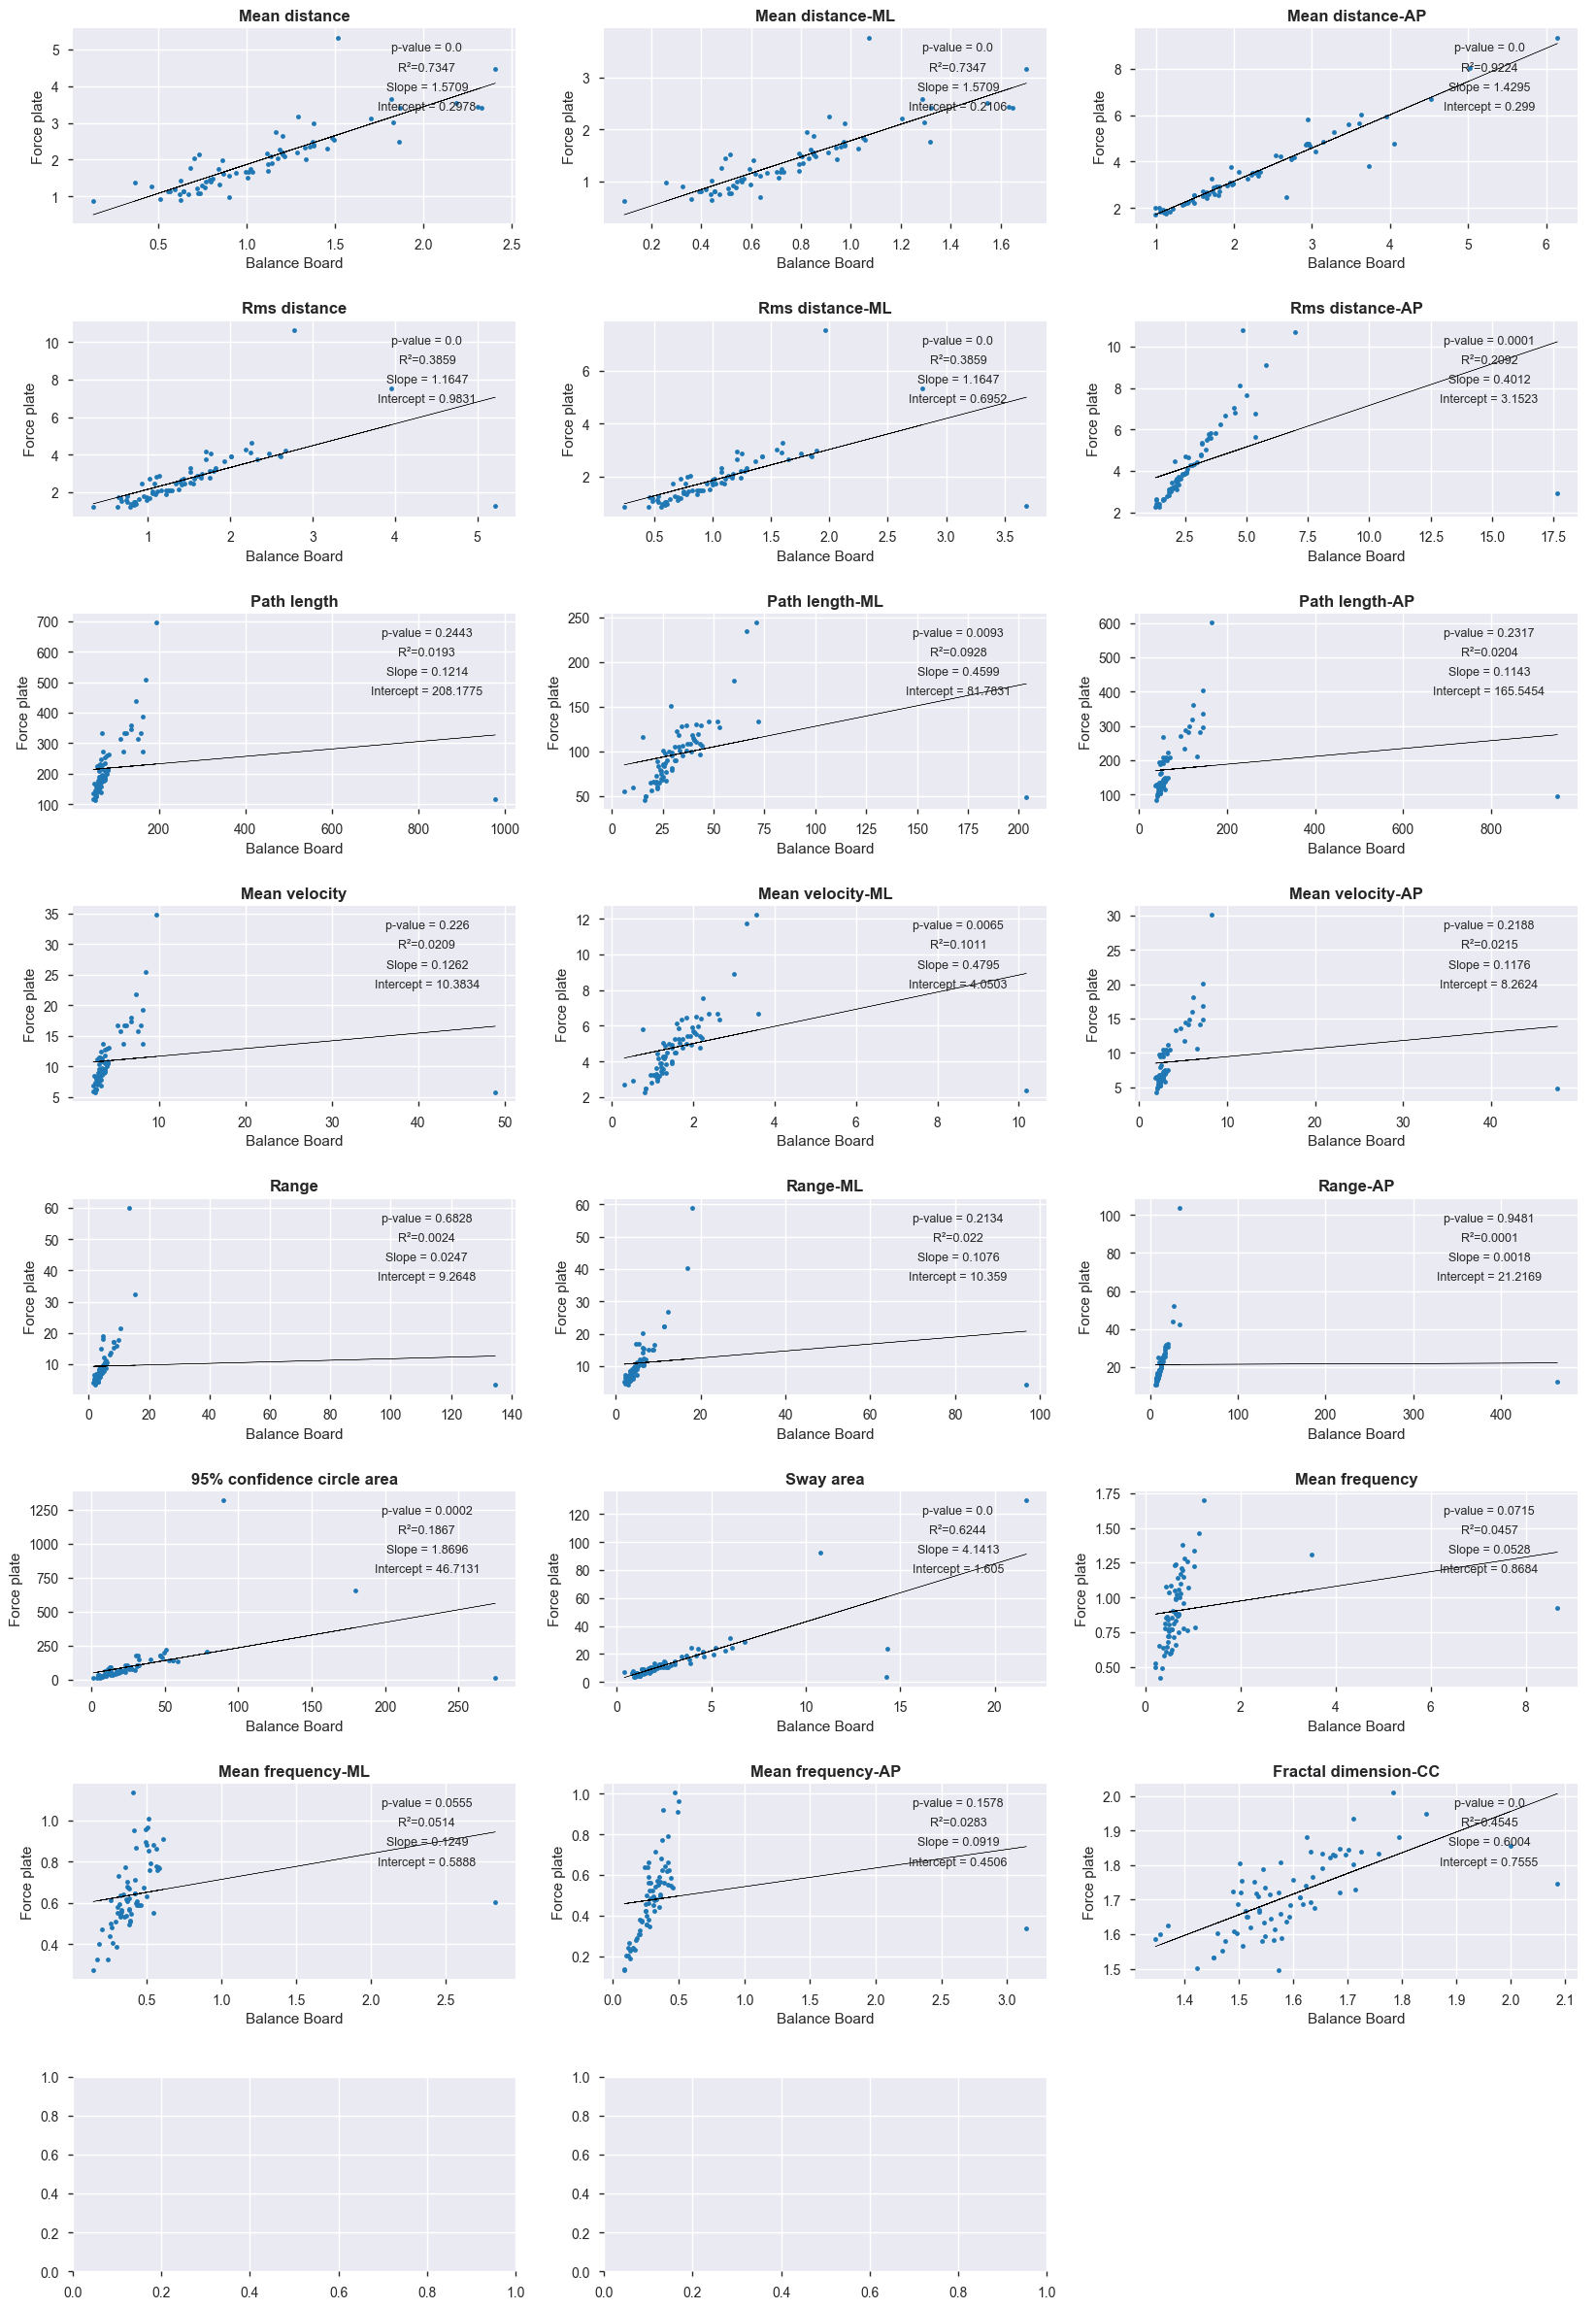

In [96]:
plot_correlation(wbb_time, fp_time_cut)

### 2.5 Bland and Altman plots + LOA (limit of agreement)

In [97]:
def bland_altman_plot(df1, df2, name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(8,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        
        data1 = np.asarray(x)
        data2 = np.asarray(y)
        mean = np.mean([x, y], axis=0)
        diff = x - y               
        md = np.mean(diff)               
        sd = np.std(diff, axis=0)

        ax.scatter(mean, diff, marker='.',s=100, color = "gray")
        ax.axhline(md,color='tomato', linestyle='--')
        ax.axhline(md + 2*sd, color='teal', linestyle='--')
        ax.axhline(md - 2*sd, color='teal', linestyle='--')
        ax.set_xlabel('Mean of the two systems')
        ax.set_ylabel('Mean of the difference')
        ax.set_title(column, weight = 600)
        
        #ax.legend()
    plt.savefig("results/{}_bland_altman_plots.png".format(name), bbox_inches='tight')

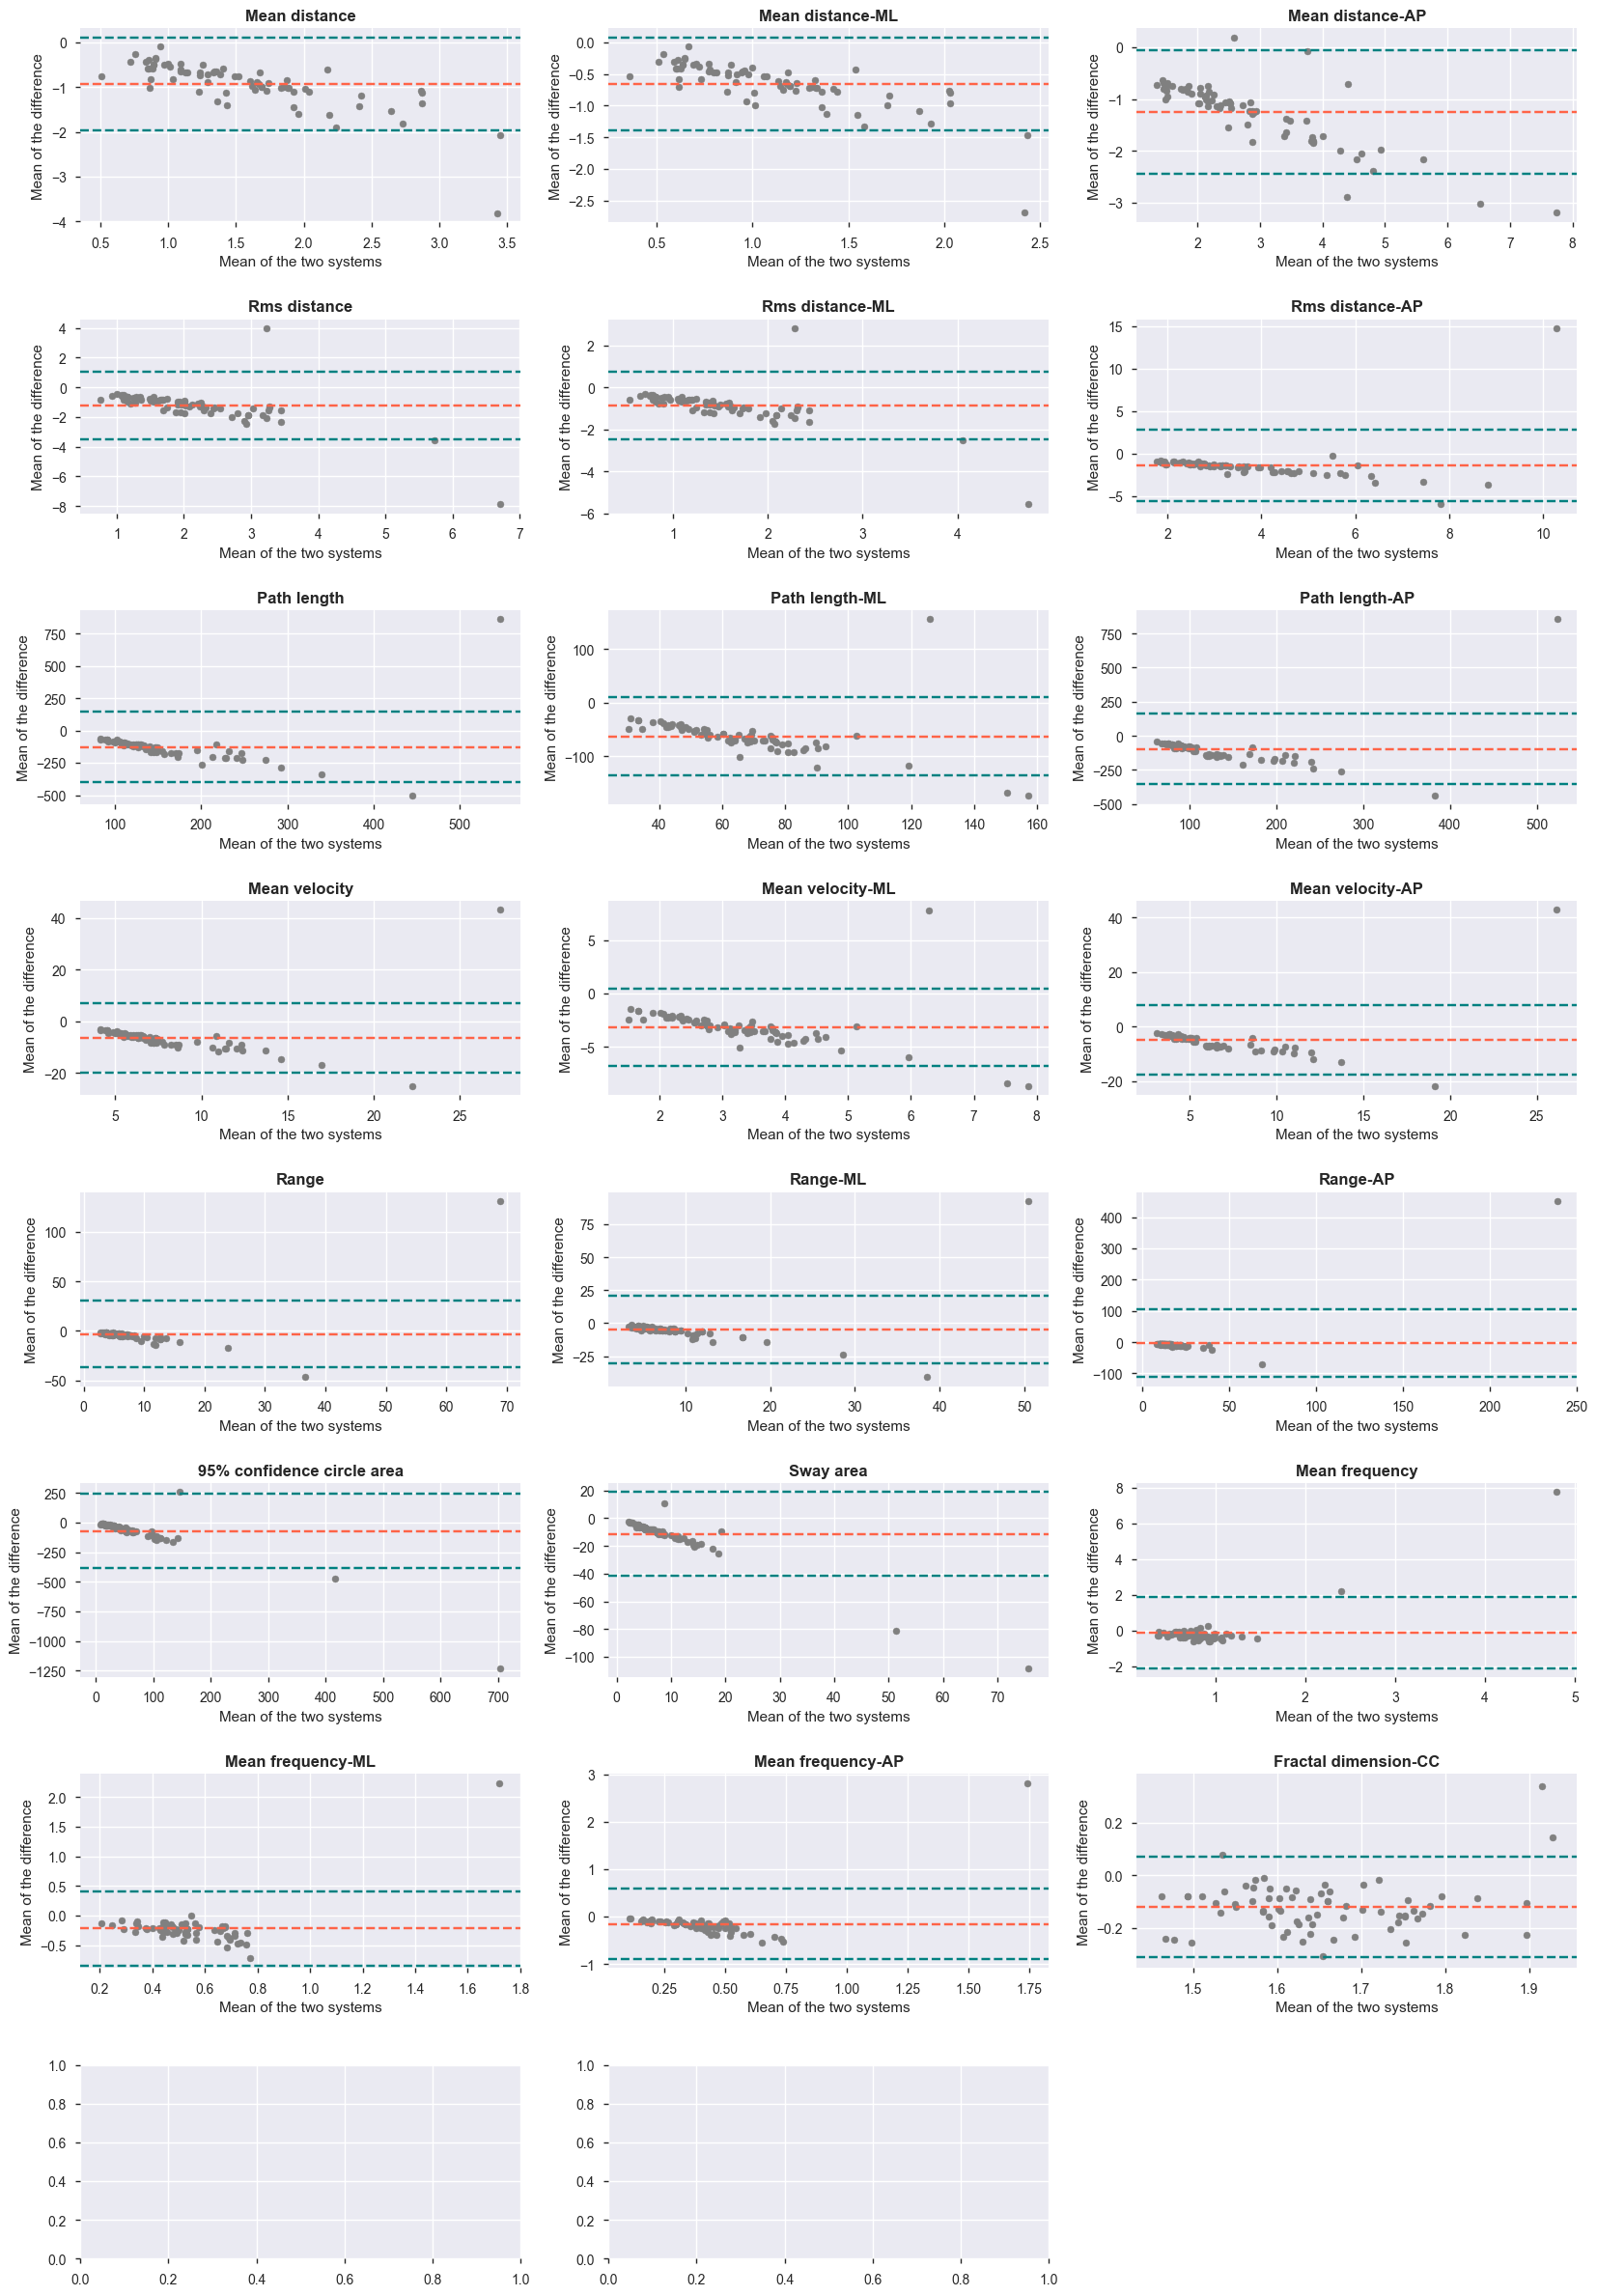

In [98]:
bland_altman_plot(wbb_time, fp_time_cut)

### 2.6  Intraclass correlation coefficient (ICC) 



In [99]:
from rpy2.robjects import DataFrame, FloatVector, pandas2ri
from rpy2.robjects.packages import importr

In [100]:
def compute_ICC(df1, df2):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: http://www.personality-project.org/r/html/ICC.html

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    psych = importr("psych")
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        x = df1[column]
        y = df2[column]

        try:
            r_df = DataFrame({"WBB feature": FloatVector(x),
                              "FP feature": FloatVector(y)})
            # Compute the two way mixed ICC
            icc_res = psych.ICC(r_df)
            iccs_r_df = icc_res[0]
            iccs_df = pandas2ri.ri2py(iccs_r_df)

            # Select the ICC that corresponds to the 2 way mixed model (see links above)
            icc = iccs_df.iloc[5]["ICC"]
            icc_lower_bound = iccs_df.iloc[5]["lower bound"]
            icc_upper_bound = iccs_df.iloc[5]["upper bound"]
            icc_result = "{}({}, {})".format(round(icc, 4), round(icc_lower_bound, 4), round(icc_upper_bound, 4))

            # Store the results
            result_dict[column] = {}
            result_dict[column]["ICC"] = icc_result

        except (RuntimeWarning, Exception) as err:
            logger.error("Problem with feature: {}.\n{}".format(column, err), exc_info=True, stack_info=True)
            pass

    return result_dict

In [101]:
ICC_results = compute_ICC(wbb_time, fp_time)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:196: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [102]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [103]:
ICC_results_df

,ICC
Mean distance,"0.8378(0.7407, 0.8985)"
Mean distance-ML,"0.8378(0.7407, 0.8985)"
Mean distance-AP,"0.9413(0.9062, 0.9633)"
Rms distance,"0.6807(0.4896, 0.8002)"
Rms distance-ML,"0.6807(0.4896, 0.8002)"
Rms distance-AP,"0.624(0.399, 0.7647)"
Path length,"0.2421(-0.2114, 0.5258)"
Path length-ML,"0.4381(0.102, 0.6485)"
Path length-AP,"0.2445(-0.2075, 0.5273)"
Mean velocity,"0.2505(-0.198, 0.531)"
